<a href="https://colab.research.google.com/github/mike-ferguson/frozen_lake/blob/main/mef8dd_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Mike Ferguson (mef8dd)

## Applying Successor Representation to the Slippery Lake Problem



## Introduction:

In this project, I attempt to solve the slippery lake problem from the OpenAI Gym, using the sucessor representation. This notebook outlines my trials of experimenting with the policy and reward of the agent, and trying out different combinations of both. The notebook is lengthy, with each section being an entirely new experiment with explanations with as to why it was chosen. I chose 4 different policies/reward schemes that I thought would best represent an attempt to solve this porblem. Final results are sumamrized at the end. The Experiment is outlined below:


1. **Problem**: With slippery = true, the agent has a much harder time navigating the frozen lake. 
2.   **Hypothesis**: That changing the policy will allow the agent to naivagte the lake successfully by learning. 
3. **Constants**: World Size (8x8), training iterations (1000), slippery= true, all parameters held constant at start.
4. **Variables**: Changing the Policies for the agent, and reward mechanisms
5. **Evaluation Criteria:** Average Reward - The higher the reward, the better the agent learned to reach the goal. 


## The Changes (Experiments):

1. **Ground Truth**: Pick a random action. (Uniformly Distributed)
2.   **The Lucky Dog (Policy) :** For 50% of the time, move according to random action. For 25% of time, move straight down. For the remainder 25%, move to the right. (Uniformly Distributed) 
3. **Mercy (Reward/M Learning)**: Do not learn when intended action was right, but slippery kicked in. That is, only learn when agent moved in direciton that was intended.
4. **The Las Vegas (Reward):** Increase the reward dramatically when the intended action resulted in ending up in the correct spot. That is, get a boost in reward when slippery did not kick in.









#Part 1: Admin Downloads and setting up packages


In [ ]:
# to install more libraries
!pip install gym

# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import matplotlib.pyplot as plt   # plotting

from IPython.display import display, clear_output
import time

import gym
from gym.envs.toy_text import frozen_lake

# Part 2: Establishing ground truth with slippery = true
## In this notebook seciton, the code is identical to the code provided in class, and mainly serves to see what the default policy does on a slippery lake. 


In [ ]:
# ******************************************************************************************************
# Step 1: Set Slippery To True: Now the agent will not always end end where inteded
# The object of this porject is to see if experimenting with the Policy 
# can lead to an agent that is able to successfully navigate the lake, 
# even with the slippery setting on.
# ******************************************************************************************************



# define the environment
size = 8
p_frozen = 0.8
slippery = True 

# generate a random map
desc = frozen_lake.generate_random_map(size=size, p=p_frozen)
env = frozen_lake.FrozenLakeEnv(desc=desc,
                                is_slippery=slippery)


In [ ]:
# ******************************************************************************************************
# Step 2: Code to define parameters and policy - (defualt policy)
#
#   POLICY: GROUND TRUTH
#
#   REASON FOR POLICY (HYPOTHESIS):
#   None in this case. Chosen by Professor to act as ground truth. 
#
#   REASON FOR POLICY NAME: Nothing special, just ground truth. 
#
# ******************************************************************************************************

# params
gamma = .99
alpha = .5
rho = .25
tau = 20.0
p_rand = 0.0
hole_penalty = -1.0
off_board_penalty = -0.0

# set up our agent
n_actions = env.action_space.n
n_states = env.observation_space.n
states = np.eye(n_states)
rewards = np.zeros(n_states)
M = np.zeros((n_actions, n_states, n_states))
scores = []

# define a policy
def pick_action(f0, M, rewards, tau, p_rand=0.0):
    # apply policy to pick action
    if p_rand > 0.0 and np.random.rand() < p_rand:
        # pick a random action
        action = env.action_space.sample()
    else:
        Q = np.dot(np.dot(M, f0), rewards)
        pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
        action = np.argmax(np.random.rand() < np.cumsum(pQ))
    return action



  (Left)
SFFFFFHF
FFHFFHFF
HFFFFHFF
FHFFFFFF
FFHFFFHF
FFHFFFFH
FFFFFFFF
FFHFFFHG
('LEFT', 9.467600844281062e-05) ('DOWN', 1.3967924256178067e-07) ('RIGHT', 5.4460012078648866e-06) ('UP', 0.9998997383111068)
Average Reward:  -0.7125668449197861


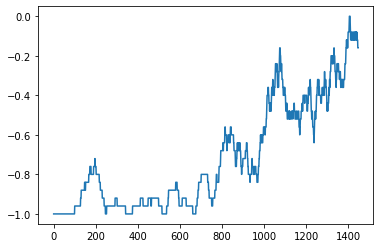

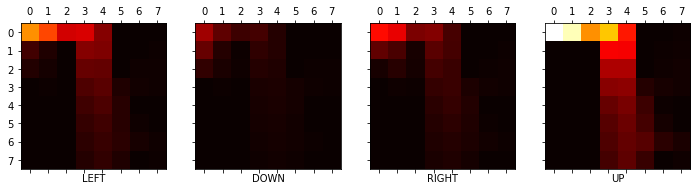

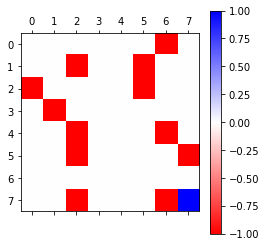

In [ ]:
# ******************************************************************************************************
# Step 3: Actually Running the code. This section trains the model and 
# evaulates it using various graphs.
# ******************************************************************************************************


for r in range(1000):
    # reset for new attempt at recovering the frisbee
    observation = env.reset()
    last_obs = observation
    f0 = states[observation]
    t0 = states[observation]
    
    for i in range(1000):
        # pick an action
        action = pick_action(f0, M, rewards, tau, p_rand=p_rand)
        
        # observe new state
        observation, reward, done, info = env.step(action)
        
        # turn the new state into a vector representation
        f1 = states[observation]

        # learn via successor representation
        # prediction from previous state
        p0 = np.dot(M[action], f0)
        
        # observed outcome, plus discounted future prediction
        # when following that policy
        f1_action = pick_action(f1, M, rewards, tau, p_rand=p_rand)
        o1 = (f1 + gamma*(np.dot(M[f1_action], f1)))
        
        # update the association for that action
        M[action] += alpha * np.outer((o1 - p0), t0)

        # update context (eligibility trace)
        t1 = rho*t0 + (1-rho)*f1

        # process the reward if any
        if done and reward==0:
            # get negative rewards for falling in a hole
            reward = hole_penalty
            
        if last_obs == observation:
            # action gave rise to no change in movement
            reward = off_board_penalty

        # update our representation of rewards/punishments at the observed state
        rewards[observation] += alpha*(reward - rewards[observation])

        # see if we're done
        if done:
            #print("Episode finished after {} timesteps with reward {}".format(i+1, reward))
            # save out our final reward/punishment
            scores.append(reward)
            break

        # prepare for next iteration
        f0 = f1
        t0 = t1
        last_obs = observation

# render the final state
env.render()

# plot a moving average of scores
N=50
plt.plot(np.convolve(scores, np.ones((N,))/N, mode='valid'))



# see predicted outcomes for different actions at a particular state
state = 0
fig,ax = plt.subplots(1, 4, figsize=(12,5), sharex=True, sharey=True)
acts = ['LEFT', 'DOWN', 'RIGHT', 'UP']

# get the min and max values for plot normalization
pmin = 0.0
pmax = 0.0
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    pmin = min(pred.min(), pmin)
    pmax = max(pred.max(), pmax)

# do the plot
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    ax[i].matshow((pred.reshape((size, size))), vmin=pmin, vmax=pmax, cmap='hot')
    ax[i].set_xlabel(acts[i])

# print out model-based predictions for state-actions
Q = np.dot(np.dot(M, states[state]), rewards)
pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
print(*zip(acts, pQ))

# see what state rewards it's learned
plt.matshow(rewards.reshape((size, size)), cmap='bwr_r', vmin=-1, vmax=1.0)
plt.colorbar()

average_reward = np.average(scores)
print("Average Reward: ", average_reward)



## Reflection on Experiment 1: Ground Truth

In this case, the performance of the model was not the greatest:

* World Size: **8x8**
* Training iterations: **1000**
* Ability to Navigate Sucessfully: **No**
* Average Reward: **-0.7125**
* Was able to Learn where holes are: **Yes**
* Ability to learn where goal is: **Yes**

Final comments: 
In this situation, it appears that the model is learning where the holes and the goals are, based on the map of reward  with respect to location. However, it still cannot seem to navigate sucessfully to the goal. The biggest reason is obviously the slippery setting: Even thought the agent knows that the holes are where they are and the goal is correct, it still is not going to where it wants. The average reward was also very low, as -0.7125, but increasing as the number of iterations increased. 



#Part 3: Experiment Number 2: The Lucky Dog

In this notebook seciton, the code is identical to the above, with the only thing changing as the policy, explained below.

In [ ]:
# ******************************************************************************************************
# Step 1: Set Slippery To True: Now the agent will not always end end where inteded
# The object of this porject is to see if experimenting with the Policy 
# can lead to an agent that is able to successfully navigate the lake, 
# even with the slippery setting on.
# ******************************************************************************************************



# define the environment
size = 8
p_frozen = 0.8
slippery = True 

# generate a random map
desc = frozen_lake.generate_random_map(size=size, p=p_frozen)
env = frozen_lake.FrozenLakeEnv(desc=desc,
                                is_slippery=slippery)


In [ ]:
# ******************************************************************************************************
# Step 2: Code to define parameters and policy - (The Lucky Dog Policy)
#
#   POLICY: The Lucky Dog 
#
#   REASON FOR POLICY (HYPOTHESIS):
#   Instead of trying to pick a random action everytime, just do so half of the time. The other half of the time, 
#   either move down or to the right. The reason behind the right/down is because the world always has the 
#   goal in the bottom right corner, so progress can always be made. This would also theorteiclaly cut down 
#   on the number of moves needed, as the number of up/left moves are decresed. This policy also reflects the 
#   pretty human notion of getting outside help on the information of your environment, and exploiting it. 
#
#   REASON FOR POLICY NAME: 
#   In order for the agent to learn, it has to get lucky, similiar to 
#   how a dog gets lucky when training by stumbling across the desired action, then being reinforced. 
#   Everyone needs a little luck, eh?
#
# ******************************************************************************************************

# params
gamma = .99
alpha = .5
rho = .25
tau = 20.0
p_rand = 0.0
hole_penalty = -1.0
off_board_penalty = -0.0

# set up our agent
n_actions = env.action_space.n
n_states = env.observation_space.n
states = np.eye(n_states)
rewards = np.zeros(n_states)
M = np.zeros((n_actions, n_states, n_states))
scores = []

# define a policy
def pick_action(f0, M, rewards, tau, p_rand=0.0):
    # apply policy to pick action
    if p_rand > 0.0 and np.random.rand() < p_rand:
        # pick a random action
        action = env.action_space.sample()
    else:
        rand_num = np.random.rand()       
        if 0 <= rand_num <= 0.50:
          Q = np.dot(np.dot(M, f0), rewards)
          pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
          action = np.argmax(np.random.rand() < np.cumsum(pQ))
        elif 0.50 < rand_num <= 0.75:
          action = 2 # move right 
        else: 
          action = 1 # move down
    return action



  (Right)
SHHHFFFH
FFFHFFFF
HFFFFFFF
FFFFFFFF
FHFFFFFF
HFFHFFFF
FFFFHFFH
HFFFFFFG
('LEFT', 0.37455590287699847) ('DOWN', 0.40791768236873893) ('RIGHT', 0.21693976263627038) ('UP', 0.0005866521179922102)
Average Reward:  -0.99


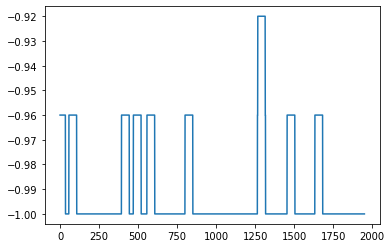

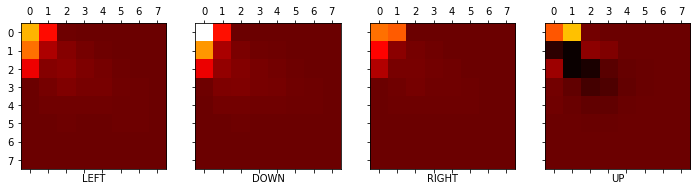

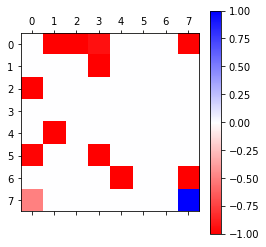

In [ ]:
# ******************************************************************************************************
# Step 3: Actually Running the code. This section trains the model and 
# evaulates it using various graphs.
# ******************************************************************************************************


for r in range(1000):
    # reset for new attempt at recovering the frisbee
    observation = env.reset()
    last_obs = observation
    f0 = states[observation]
    t0 = states[observation]
    
    for i in range(1000):
        # pick an action
        action = pick_action(f0, M, rewards, tau, p_rand=p_rand)
        
        # observe new state
        observation, reward, done, info = env.step(action)
        
        # turn the new state into a vector representation
        f1 = states[observation]

        # learn via successor representation
        # prediction from previous state
        p0 = np.dot(M[action], f0)
        
        # observed outcome, plus discounted future prediction
        # when following that policy
        f1_action = pick_action(f1, M, rewards, tau, p_rand=p_rand)
        o1 = (f1 + gamma*(np.dot(M[f1_action], f1)))
        
        # update the association for that action
        M[action] += alpha * np.outer((o1 - p0), t0)

        # update context (eligibility trace)
        t1 = rho*t0 + (1-rho)*f1

        # process the reward if any
        if done and reward==0:
            # get negative rewards for falling in a hole
            reward = hole_penalty
            
        if last_obs == observation:
            # action gave rise to no change in movement
            reward = off_board_penalty

        # update our representation of rewards/punishments at the observed state
        rewards[observation] += alpha*(reward - rewards[observation])

        # see if we're done
        if done:
            #print("Episode finished after {} timesteps with reward {}".format(i+1, reward))
            # save out our final reward/punishment
            scores.append(reward)
            break

        # prepare for next iteration
        f0 = f1
        t0 = t1
        last_obs = observation

# render the final state
env.render()

# plot a moving average of scores
N=50
plt.plot(np.convolve(scores, np.ones((N,))/N, mode='valid'))



# see predicted outcomes for different actions at a particular state
state = 0
fig,ax = plt.subplots(1, 4, figsize=(12,5), sharex=True, sharey=True)
acts = ['LEFT', 'DOWN', 'RIGHT', 'UP']

# get the min and max values for plot normalization
pmin = 0.0
pmax = 0.0
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    pmin = min(pred.min(), pmin)
    pmax = max(pred.max(), pmax)

# do the plot
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    ax[i].matshow((pred.reshape((size, size))), vmin=pmin, vmax=pmax, cmap='hot')
    ax[i].set_xlabel(acts[i])

# print out model-based predictions for state-actions
Q = np.dot(np.dot(M, states[state]), rewards)
pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
print(*zip(acts, pQ))

# see what state rewards it's learned
plt.matshow(rewards.reshape((size, size)), cmap='bwr_r', vmin=-1, vmax=1.0)
plt.colorbar()

average_reward = np.average(scores)
print("Average Reward: ", average_reward)



## Reflection on Experiment 2: The Lucky Dog

In this case, the dog was not so lucky:

* World Size: **8x8**
* Training iterations: **1000**
* Ability to Navigate Sucessfully: **No**
* Average Reward: **-0.99**
* Was able to Learn where holes are: **Yes, but less so then Ground Truth (GT)**
* Ability to learn where goal is: **Yes**

Final comments: 
With this policy, the agent did signifacntly worse then ground truth, with an average reward of -0.99 vs -0.71, showing that the agent spent way more time in holes then it should have. A few more things to note from this trial: The graph of the moving average of scores hovers around the -0.9 to -1.0 range, indicating that most of the time was spent in holes getting punished. There are multiple spikes in the graph, which can be atrributed to getting lucky with the downwasrds and righwards movements. 

## Overall Verdict: Significantly Worse then Ground truth (28.3% worse)


#Part 4: Experiment Number 3: Mercy

In this notebook seciton, the code is identical to the above, with the only thing changing being the reward mechanism, explained below.

In [ ]:
# ******************************************************************************************************
# Step 1: Set Slippery To True: Now the agent will not always end end where inteded
# The object of this porject is to see if experimenting with the Policy 
# can lead to an agent that is able to successfully navigate the lake, 
# even with the slippery setting on.
# ******************************************************************************************************



# define the environment
size = 8
p_frozen = 0.8
slippery = True 

# generate a random map
desc = frozen_lake.generate_random_map(size=size, p=p_frozen)
env = frozen_lake.FrozenLakeEnv(desc=desc,
                                is_slippery=slippery)


In [ ]:
# ******************************************************************************************************
# Step 2: Code to define parameters and policy 
#
# Policy is same as Ground Truth
#
# ******************************************************************************************************

# params
gamma = .99
alpha = .5
rho = .25
tau = 20.0
p_rand = 0.0
hole_penalty = -1.0
off_board_penalty = -0.0

# set up our agent
n_actions = env.action_space.n
n_states = env.observation_space.n
states = np.eye(n_states)
rewards = np.zeros(n_states)
M = np.zeros((n_actions, n_states, n_states))
scores = []

# define a policy
def pick_action(f0, M, rewards, tau, p_rand=0.0):
    # apply policy to pick action
    if p_rand > 0.0 and np.random.rand() < p_rand:
        # pick a random action
        action = env.action_space.sample()
    else:
        Q = np.dot(np.dot(M, f0), rewards)
        pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
        action = np.argmax(np.random.rand() < np.cumsum(pQ))
    return action


  (Right)
SFFHFHHF
FFFFHFHF
FFFFFFFH
HFFFFFFF
FFFFFFFF
FFFFHFFF
FFFFHHFF
FFFHFFFG
('LEFT', 0.45630366380621157) ('DOWN', 0.0633491479258899) ('RIGHT', 0.021808609981959347) ('UP', 0.4585385782859392)
Average Reward:  -0.33645018701122065


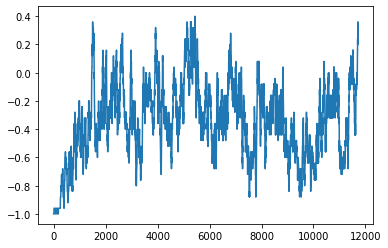

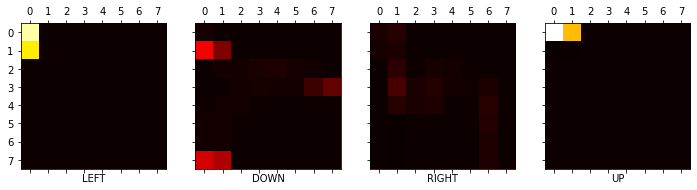

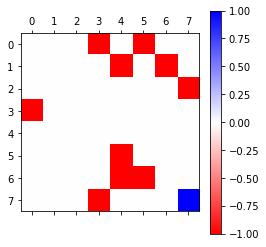

In [ ]:
# ******************************************************************************************************
# Step 3: Actually Running the code. This section trains the model and 
# evaulates it using various graphs.
#
#   Reward Scheme: Mercy
#
#   REASON FOR REWARD (HYPOTHESIS):
#   The biggest issue I think that is happening here that is preventing the correct
#   navigation of the agent is the fact that it is being still learning when it makes a correct 
#   choice but ended up in the wrong spot- that is, even when it chose an aciton that was correct, 
#   if slipper happend and it ended up in the wrong spot, then it was learning to be punished for that.
#   So, if the model only learned when slippery did not occur, then it would be able to navigate 
#   correctly. Only update M when slippery did not happen. Theoreticlaly this should work, becuase now it is 
#   effectivly the problem with slippery = False, although it would take longer to train. 
#
#   REASON FOR REWARD NAME: 
#   You should not punish the agent for doing what it thought wa correct, only to have the enviornment
#   make it fail! It is not it's fault, so have Mercy!
#
# ******************************************************************************************************
#acts = ['LEFT', 'DOWN', 'RIGHT', 'UP']

for r in range(1000):
    # reset for new attempt at recovering the frisbee
    observation = env.reset()
    last_obs = observation
    f0 = states[observation]
    t0 = states[observation]
    
    for i in range(1000):
        # pick an action
        action = pick_action(f0, M, rewards, tau, p_rand=p_rand)
        # print("Action Chosen: ", f0)
        
        # get where you were in the world:
        maximum = np.max(f0)
        old_position = np.where(f0 == maximum)[0][0]

        # observe new state
        observation, reward, done, info = env.step(action)
        new_position = observation


        # calculates the actual action that was taken based on grid math:
        if new_position - old_position == 8: # means you actually moved down 1
          actual_action = 1
        elif new_position - old_position == -8: # means you actually moved up 1
          actual_action = 3
        elif new_position - old_position == 1: # means you actually moved right 1
          actual_action = 2
        elif new_position - old_position == -1: # means you actually moved left 1
          actual_action = 0
        elif new_position - old_position == 0: # means you went off the grid, either left or up ***** 
          rand_num = np.random.rand()
          if rand_num <= 0.5:
            actual_action = 0
          else: 
            actual_action = 3
        

        # turn the new state into a vector representation
        f1 = states[observation]
        

        # learn via successor representation
        # prediction from previous state
        p0 = np.dot(M[action], f0)
        
        # observed outcome, plus discounted future prediction
        # when following that policy
        f1_action = pick_action(f1, M, rewards, tau, p_rand=p_rand)
        

        o1 = (f1 + gamma*(np.dot(M[f1_action], f1)))
        

        #************  THE CHANGE FROM GROUND TRUTH ************
        # update the association for that action 
        intended_action = action
        actual_action = f1_action

        if intended_action == actual_action:
          M[action] += alpha * np.outer((o1 - p0), t0)


        # update context (eligibility trace)
        t1 = rho*t0 + (1-rho)*f1

        # process the reward if any
        if done and reward==0:
            # get negative rewards for falling in a hole
            reward = hole_penalty
            
        if last_obs == observation:
            # action gave rise to no change in movement
            reward = off_board_penalty

        # update our representation of rewards/punishments at the observed state
        rewards[observation] += alpha*(reward - rewards[observation])

        # see if we're done
        if done:
            #print("Episode finished after {} timesteps with reward {}".format(i+1, reward))
            # save out our final reward/punishment
            scores.append(reward)
            break

        # prepare for next iteration
        f0 = f1
        t0 = t1
        last_obs = observation

# render the final state
env.render()

# plot a moving average of scores
N=50
plt.plot(np.convolve(scores, np.ones((N,))/N, mode='valid'))



# see predicted outcomes for different actions at a particular state
state = 0
fig,ax = plt.subplots(1, 4, figsize=(12,5), sharex=True, sharey=True)
acts = ['LEFT', 'DOWN', 'RIGHT', 'UP']

# get the min and max values for plot normalization
pmin = 0.0
pmax = 0.0
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    pmin = min(pred.min(), pmin)
    pmax = max(pred.max(), pmax)

# do the plot
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    ax[i].matshow((pred.reshape((size, size))), vmin=pmin, vmax=pmax, cmap='hot')
    ax[i].set_xlabel(acts[i])

# print out model-based predictions for state-actions
Q = np.dot(np.dot(M, states[state]), rewards)
pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
print(*zip(acts, pQ))

# see what state rewards it's learned
plt.matshow(rewards.reshape((size, size)), cmap='bwr_r', vmin=-1, vmax=1.0)
plt.colorbar()

average_reward = np.average(scores)
print("Average Reward: ", average_reward)



## Reflection on Experiment 3: Mercy

In this case, having mercy proved beneficial:

* World Size: **8x8**
* Training iterations: **1000**
* Ability to Navigate Sucessfully: **No**
* Average Reward: **-0.34**
* Was able to Learn where holes are: **Yes**
* Ability to learn where goal is: **Yes**

Final comments: 
With this change to the reward system, only updating M when the actual action was the intended action, the model performed significantly better then ground truth (-0.34 vs -0.71 average reward). A few things to note: The way it was implemented worked by gathering the action taken and intended action, and reverse engineering the action that actully occured by grid math. However, the model was not perfect, as the grid math had a hard time accounting for the cases where the agent moved off world. Also, The model was able to perfeclty identify the goal and the holes, and the Successsor Representation map for the RIGHT picture shows a nascent path beign formed to the goal. Running the simulaitn over 5,000 instead of 1,000, as shown, did not result in a subsatntial improvement, either. 

## Overall Verdict: Significantly Better then Ground truth (60.8% better)


#Part 5: Experiment Number 4: The Las Vegas

In this notebook seciton, the code is identical to the above, with the only thing changing being the reward mechanism, explained below.

In [ ]:
# ******************************************************************************************************
# Step 1: Set Slippery To True: Now the agent will not always end end where inteded
# The object of this porject is to see if experimenting with the Policy 
# can lead to an agent that is able to successfully navigate the lake, 
# even with the slippery setting on.
# ******************************************************************************************************



# define the environment
size = 8
p_frozen = 0.8
slippery = True 

# generate a random map
desc = frozen_lake.generate_random_map(size=size, p=p_frozen)
env = frozen_lake.FrozenLakeEnv(desc=desc,
                                is_slippery=slippery)

In [ ]:
# ******************************************************************************************************
# Step 2: Code to define parameters and policy 
#
# Policy is same as Ground Truth
#
# ******************************************************************************************************

# params
gamma = .99
alpha = .5
rho = .25
tau = 20.0
p_rand = 0.0
hole_penalty = -1.0
off_board_penalty = -0.0

# set up our agent
n_actions = env.action_space.n
n_states = env.observation_space.n
states = np.eye(n_states)
rewards = np.zeros(n_states)
M = np.zeros((n_actions, n_states, n_states))
scores = []

# define a policy
def pick_action(f0, M, rewards, tau, p_rand=0.0):
    # apply policy to pick action
    if p_rand > 0.0 and np.random.rand() < p_rand:
        # pick a random action
        action = env.action_space.sample()
    else:
        Q = np.dot(np.dot(M, f0), rewards)
        pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
        action = np.argmax(np.random.rand() < np.cumsum(pQ))
    return action

  (Up)
SFHFFFFH
FFFFHFFF
FFHFFFFH
FFFFFFFF
FFFFFHFH
FFFFFFFF
HFFFFFFF
FHFFFFFG
('LEFT', 0.5219403096515212) ('DOWN', 3.949834988475145e-10) ('RIGHT', 0.47798822348297076) ('UP', 7.14664705245654e-05)
Average Reward:  0.853


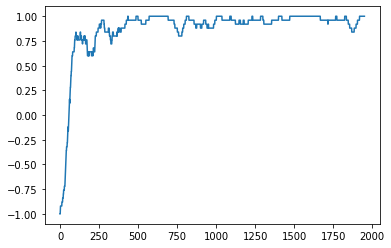

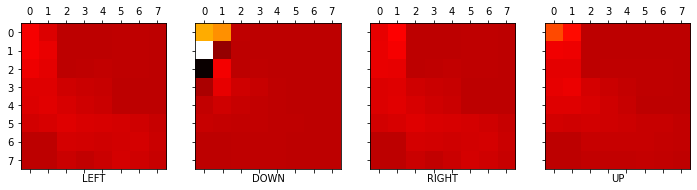

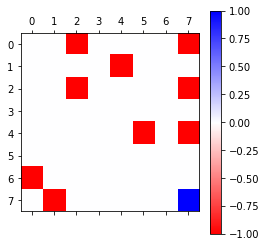

In [ ]:
# ******************************************************************************************************
# Step 3: Actually Running the code. This section trains the model and 
# evaulates it using various graphs.
#
#   Reward Scheme: The Las Vegas
#
#   REASON FOR REWARD (HYPOTHESIS):
#   The thought behind this scheme is the we should increase the reward if the agent took its action and ended up where 
#   it wanted to- that is, increase the reward if slippery did not happen. The rationale was that these iterations would contribute 
#   stronger to the reward, increasing the avergae reward and proving better performance. This used the same method of 
#   getting the actions as the above section. This one is more neurotranstimmer based(if that is a thing?) because it 
#   works off of the principle that you get higher rewards when your intended action matches what actually happened.

#
#   REASON FOR REWARD NAME: 
#   People seek the things that give them a increase in dopamine, even if the odds of them getting it is random. This is 
#   like gambling, so thats why its tthe Las Vegas!
# ******************************************************************************************************

for r in range(1000):
    # reset for new attempt at recovering the frisbee
    observation = env.reset()
    last_obs = observation
    f0 = states[observation]
    t0 = states[observation]
    
    for i in range(1000):
        # pick an action
        action = pick_action(f0, M, rewards, tau, p_rand=p_rand)
        # print("Action Chosen: ", f0)
        
        # get where you were in the world:
        maximum = np.max(f0)
        old_position = np.where(f0 == maximum)[0][0]


        # observe new state
        observation, reward, done, info = env.step(action)
        new_position = observation

        # calculates the actual action that was taken based on grid math:
        if new_position - old_position == 8: # means you actually moved down 1
          actual_action = 1
        elif new_position - old_position == -8: # means you actually moved up 1
          actual_action = 3
        elif new_position - old_position == 1: # means you actually moved right 1
          actual_action = 2
        elif new_position - old_position == -1: # means you actually moved left 1
          actual_action = 0
        elif new_position - old_position == 0: # means you went off the grid, either left or up ***** 
          rand_num = np.random.rand()
          if rand_num <= 0.5:
            actual_action = 0
          else: 
            actual_action = 3
        

        # turn the new state into a vector representation
        f1 = states[observation]
        

        # learn via successor representation
        # prediction from previous state
        p0 = np.dot(M[action], f0)
        
        # observed outcome, plus discounted future prediction
        # when following that policy
        f1_action = pick_action(f1, M, rewards, tau, p_rand=p_rand)
        

        o1 = (f1 + gamma*(np.dot(M[f1_action], f1)))
        
        # update the association for that action 
        intended_action = action
        actual_action = f1_action

        
        M[action] += alpha * np.outer((o1 - p0), t0)


        # update context (eligibility trace)
        t1 = rho*t0 + (1-rho)*f1

        # process the reward if any
        if done and reward==0:
            # get negative rewards for falling in a hole
            reward = hole_penalty
            
        if last_obs == observation:
            # action gave rise to no change in movement
            reward = off_board_penalty
            
        # ************  THE CHANGE FROM MERCY ************

        # update our representation of rewards/punishments at the observed state 
        if intended_action == actual_action:
          rewards[observation] +=  (alpha*(2 * reward - rewards[observation]))
        else: 
          rewards[observation] +=  (alpha*(reward - rewards[observation]))

        # ************  THE CHANGE FROM MERCY ************

        # see if we're done
        if done:
            #print("Episode finished after {} timesteps with reward {}".format(i+1, reward))
            # save out our final reward/punishment
            scores.append(reward)
            break

        # prepare for next iteration
        f0 = f1
        t0 = t1
        last_obs = observation

# render the final state
env.render()

# plot a moving average of scores
N=50
plt.plot(np.convolve(scores, np.ones((N,))/N, mode='valid'))



# see predicted outcomes for different actions at a particular state
state = 0
fig,ax = plt.subplots(1, 4, figsize=(12,5), sharex=True, sharey=True)
acts = ['LEFT', 'DOWN', 'RIGHT', 'UP']

# get the min and max values for plot normalization
pmin = 0.0
pmax = 0.0
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    pmin = min(pred.min(), pmin)
    pmax = max(pred.max(), pmax)

# do the plot
for i in range(n_actions):
    pred = np.dot(M, states[state])[i]
    ax[i].matshow((pred.reshape((size, size))), vmin=pmin, vmax=pmax, cmap='hot')
    ax[i].set_xlabel(acts[i])

# print out model-based predictions for state-actions
Q = np.dot(np.dot(M, states[state]), rewards)
pQ = np.exp(Q*tau)/np.exp(Q*tau).sum()
print(*zip(acts, pQ))

# see what state rewards it's learned
plt.matshow(rewards.reshape((size, size)), cmap='bwr_r', vmin=-1, vmax=1.0)
plt.colorbar()

average_reward = np.average(scores)
print("Average Reward: ", average_reward)


## Reflection on Experiment 4: The Las Vegas

In this case, the trip to Vegas was a successful one!

* World Size: **8x8**
* Training iterations: **1000**
* Ability to Navigate Sucessfully: **YES**
* Average Reward: **0.853**
* Was able to Learn where holes are: **Yes**
* Ability to learn where goal is: **Yes**

Final comments: 
Success! The agent was able to learn how to navigate the world, even with slippery is set to true, over the same training times the other experiments took. Things to note: the way it was implemented was by doubling the reward if the agent ended up where it intended - that is, slippery did not happen. This resulted in the best performance so far, with an avergae reward of 0.853. This experiment also began to learn in earnest the lake at around 150 iterations, which is very good. The holes and goal were learned, as well as nice successsor representations, with the path visible, for almost all directions. The reason this works, though, I am not entriely sure - think it is because the agent seeks the higher reward from having the slippery setting off when it's movements lined up with what it wanted. Almost like a dopamine boost of "I can't believe how lucky I am" if a human were to do this. 

## Overall Verdict: Hugely Successful! Best Performance to date, with a 220.141 % increase from gorund truth and successful navigation!


# Part 6:  Final Results and reflection

Here is a summary of my findings from the 4 different experiments I ran, displayed below in table form. Important things to note: first, the only agent that was able to solve the slippery problem was the one using the Las Vegas setup, as expained above. It was significanlty better then anything else tested, and actually solved the problem at around 150 trials. The worst was the Lucky Dog, and the other two were in the middle. Problem Solved!





In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame()
df = pd.concat([df, pd.DataFrame(np.random.randn(4, 4), index=("Ground Truth", "The Lucky Dog", "Mercy", "The Las Vegas"),
                                 columns=("Able to Navigate?", "Average Reward", "Learned Holes/Goal?", "% Increase from GT"))], axis=1)
df.iloc[0, 0] = "NO"
df.iloc[1, 0] = "NO"
df.iloc[2, 0] = "NO"
df.iloc[3, 0] = "YES"

df.iloc[0, 1] = -0.71
df.iloc[1, 1] = -0.99
df.iloc[2, 1] = -0.34
df.iloc[3, 1] = 0.85

df.iloc[0, 2] = "YES"
df.iloc[1, 2] = "YES"
df.iloc[2, 2] = "YES"
df.iloc[3, 2] = "YES"

df.iloc[0, 3] = "N/A"
df.iloc[1, 3] = -28.3
df.iloc[2, 3] = 60.8
df.iloc[3, 3] = 220.14

df

,Able to Navigate?,Average Reward,Learned Holes/Goal?,% Increase from GT
Ground Truth,NO,-0.71,YES,N/A
The Lucky Dog,NO,-0.99,YES,-28.3
Mercy,NO,-0.34,YES,60.8
The Las Vegas,YES,0.85,YES,220.14


## Thanks for a great semester!